<a href="https://www.kaggle.com/code/angelchaudhary/rmse-vs-mae-vs-r-which-metric-lies-less?scriptVersionId=292491413" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# A Comparative Case Study on Regression Evaluation Metrics to Understand Error Sensitivity, Interpretability, and Model Reliability

# Introduction

In regression problems, model performance is often judged using numerical evaluation metrics. Among the most commonly used are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R² (Coefficient of Determination). While these metrics are widely accepted, they often tell different and sometimes misleading, stories about the same model.

A model may show a low RMSE but still perform poorly on certain samples, or achieve a high R² while making large absolute errors. This raises an important question:
**Which metric reflects the true performance of a regression model, and which one “lies” under certain conditions?**

Understanding the behavior, strengths, and limitations of these metrics is crucial for making correct model selection and deployment decisions. In many real-world machine learning projects, practitioners rely on a single metric to evaluate and compare models. This can lead to:
- Over-penalizing models due to a few outliers (RMSE),
- Ignoring variance explanation while focusing only on raw errors (MAE),
- trusting high R² values without checking actual prediction quality.

### In this case study:

- Highlight how different metrics react to the same predictions

- Show scenarios where a metric can misrepresent true performance

- Build intuition on when to trust which metric

- Rather than treating metrics as black-box numbers, this notebook aims to make their behavior visually and intuitively clear.

## Approach

To answer the question “Which metric lies less?”, we'll follow a structured, experimental approach:

1. Train a regression model on a real-world dataset

2. Evaluate predictions using RMSE, MAE, and R²

3. Introduce challenging scenarios such as:

- Presence of outliers

- Uneven error distribution

- Good variance fit but poor absolute accuracy

4. Compare metric responses under each scenario

5. Analyze discrepancies between metrics and interpret why they occur

# LET'S DO IT!!!!
![FUNNY GIF](https://media1.giphy.com/media/v1.Y2lkPTc5MGI3NjExOXBsZ3VnMHZqcWM4emd1anMydDY4cWxkMjRsMjNybzBveG5yNzhkcyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9cw/zzGETTCgQlYHypN47M/giphy.gif)

## Dataset Overview

The dataset is a housing price regression dataset designed to predict the selling price of a house based on a combination of structural and location-based features. It includes variables such as house area, number of bedrooms, furnishing status, and proximity to main roads, all of which are commonly known to influence property prices.

The dataset is small yet challenging, primarily due to the presence of strong multicollinearity among features and a wide spread in house prices. This makes model evaluation non-trivial, as different regression metrics may respond differently to prediction errors.

Due to its continuous target variable, real-world relevance, and natural variance in prices, the dataset is well suited for comparing regression evaluation metrics such as RMSE, MAE, and R², and for studying how these metrics can sometimes provide conflicting interpretations of model performance.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/housing-prices-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/housing-prices-dataset


In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("/kaggle/input/housing-prices-dataset/Housing.csv")
df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished


In [4]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


## Target Variable Analysis: House Price

Before building any regression model, it is important to understand the distribution of the target variable (`price`). The shape, spread and presence of outliers in the target can significantly influence evaluation metrics such as RMSE, MAE, and R².

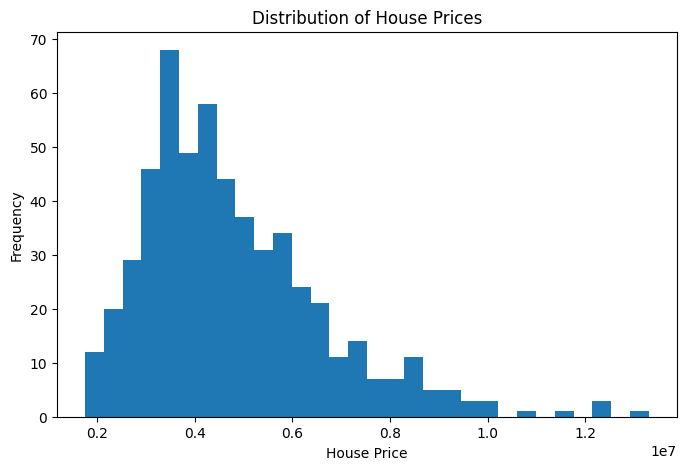

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['price'], bins=30)
plt.xlabel("House Price")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices")
plt.show()

To further inspect the presence of extreme values, a boxplot is used. Outliers in the target variable are especially important because RMSE penalizes large errors more heavily than MAE.

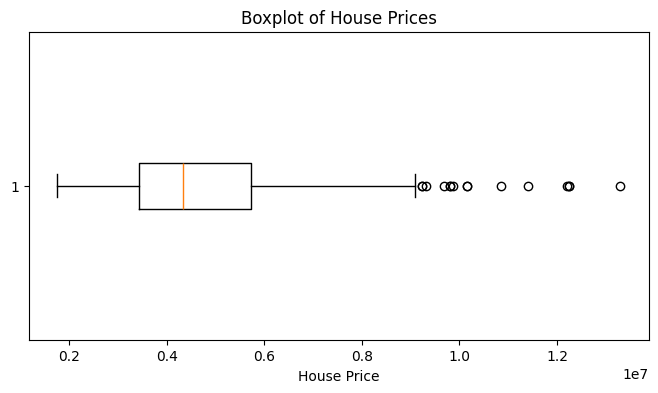

In [6]:
plt.figure(figsize=(8,4))
plt.boxplot(df['price'], vert=False)
plt.xlabel("House Price")
plt.title("Boxplot of House Prices")
plt.show()

### Observations from Target Variable Analysis

- The distribution of house prices is **positively skewed**, with a majority of properties concentrated in the lower-to-mid price range and a long tail of high-priced houses.
- The boxplot reveals the presence of **several high-value outliers**, representing premium or luxury properties.
- These extreme values increase the spread of the target variable and introduce **large potential prediction errors**.
- In such scenarios, **RMSE is expected to be highly sensitive**, as it squares large errors and disproportionately penalizes mistakes on expensive houses.
- **MAE**, on the other hand, treats all errors linearly and is therefore more robust to these outliers.
- A model may still achieve a **high R²** by explaining overall variance, even if it performs poorly on these extreme price values.

## Encode Categorical Variables

### Data Preprocessing

The dataset contains several categorical features such as furnishing status and proximity indicators. These variables are encoded into numerical form to make them suitable for regression models.

In [7]:
df_encoded = pd.get_dummies(df, drop_first=True)

The dataset is split into training and testing sets to evaluate model performance on unseen data.

In [8]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Model: Linear Regression

A simple Linear Regression model is trained as a baseline to evaluate how different regression metrics behave on the same set of predictions. This helps establish a reference point before applying more complex models or transformations.

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

## Model Evaluation Metrics

The model is evaluated using RMSE, MAE, and R² to understand how each metric interprets prediction errors differently.

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 1324506.9600914386
MAE: 970043.4039201636
R²: 0.6529242642153184


##  Interpretation of Results

- The **RMSE is significantly higher than MAE**, indicating that a subset of predictions incur very large errors.
- This behavior aligns with the earlier observation of **high-priced outliers** in the dataset, which RMSE penalizes more heavily due to squaring of errors.
- The **MAE value suggests that the typical prediction error is around ₹9.7 lakhs**, providing a more interpretable and stable measure of average
  model performance.
- Despite these large absolute errors, the model achieves an **R² score of 0.65**, meaning it explains approximately 65% of the variance in house prices.
- This demonstrates that **R² can present an optimistic view of model quality** even when prediction errors are substantial in real-world terms.

##  Which Metric Lies Less?

- **R²** may appear strong by focusing on variance explained, while ignoring the magnitude of individual prediction errors.
- **RMSE** exaggerates the impact of extreme errors, which can be misleading when outliers are rare but severe.
- **MAE** provides the most honest representation of typical model error, as it is robust to outliers and expressed in the same units as the target.

Therefore, in this case study, **MAE lies the least**, while RMSE and R² must be interpreted in context.

# Does better R² / RMSE actually mean better predictions?

## Tree-Based Model (Random Forest)

Tree-based models can capture non-linear relationships and interactions between features more effectively than linear models. We train a Random
Forest regressor to observe how RMSE, MAE, and R² change, and whether improvements in some metrics translate to better overall reliability.

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [12]:
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest R²: {r2_rf}")

Random Forest RMSE: 1398115.6668385956
Random Forest MAE: 1013968.579587156
Random Forest R²: 0.6132752494107068


### Observations: Random Forest Performance

- Contrary to expectations, the Random Forest model performs **worse than Linear Regression** across all three metrics.
- The **RMSE increases**, indicating larger errors on extreme house prices.
- The **MAE also increases**, suggesting that the average prediction error becomes less reliable.
- The **R² drops**, showing weaker overall variance explanation.

### Why Did Random Forest Perform Worse?

- The dataset is **relatively small**, which limits the effectiveness of ensemble tree-based models.
- Strong **multicollinearity** and categorical feature expansion increase feature noise for tree splits.
- Random Forests tend to **overfit small datasets**, leading to unstable predictions on unseen data.
- Linear Regression, despite its simplicity, generalizes better in this scenario due to its bias–variance tradeoff.

This result highlights that metric interpretation must always be grounded in data behavior, and not in model complexity assumptions.

# Can we “game” RMSE and R²?

## Log Transformation of Target Variable

Due to the right-skewed distribution of house prices, a logarithmic transformation is applied to the target variable. This is a common technique to reduce the influence of extreme values and stabilize variance.

In [13]:
y_log = np.log1p(y)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

lr_log = LinearRegression()
lr_log.fit(X_train_log, y_train_log)

y_pred_log = lr_log.predict(X_test_log)

In [14]:
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
mae_log = mean_absolute_error(y_test_log, y_pred_log)
r2_log = r2_score(y_test_log, y_pred_log)

print(f"Log-Scale RMSE: {rmse_log}")
print(f"Log-Scale MAE: {mae_log}")
print(f"Log-Scale R²: {r2_log}")

Log-Scale RMSE: 0.2515820760132416
Log-Scale MAE: 0.19990267828473016
Log-Scale R²: 0.6722047416501395


### Back-Transform & Evaluate in Original Units

In [15]:
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_orig = mean_absolute_error(y_test_original, y_pred_original)
r2_orig = r2_score(y_test_original, y_pred_original)

print(f"Back-transformed RMSE: {rmse_orig}")
print(f"Back-transformed MAE: {mae_orig}")
print(f"Back-transformed R²: {r2_orig}")

Back-transformed RMSE: 1314648.1954137243
Back-transformed MAE: 960123.1734346995
Back-transformed R²: 0.65807184518817


### Interpretation of Log Transformation Results

- On the logarithmic scale, both **RMSE and R² improve**, suggesting a stronger model fit and reduced error magnitude.
- However, after converting predictions back to the original price scale, the **absolute error metrics (RMSE and MAE) remain comparable to the
  baseline Linear Regression model**.
- This indicates that the apparent improvement on the log scale does not translate into a substantial reduction in real-world prediction error.
- Log transformation smooths the impact of extreme house prices, effectively reducing metric sensitivity without necessarily improving practical accuracy.

### Metric Caution

The improvement in RMSE and R² on the log scale demonstrates how evaluation metrics can appear more favorable due to transformation, even when the
model’s performance in original units remains largely unchanged.

## CONCLUSION: RMSE vs MAE vs R²

Across multiple experiments—including baseline linear regression, a tree-based model, and log-transformed targets—the following conclusions
emerge:

- **R²** consistently presents an optimistic view by focusing on variance explained rather than absolute prediction accuracy.
- **RMSE** is highly sensitive to outliers and transformations, making it volatile and occasionally misleading.
- **MAE** remains stable across models and transformations and provides the clearest interpretation of typical prediction error in real-world units.

Therefore, in the context of this housing price prediction problem, **MAE lies the least** and is the most reliable metric for practical
decision-making.